# Purpose

This notebook models and forecasts realised volatility using exponential smoothing methods, and evaluates out-of-sample performance against a naive benchmark.

Exponential smoothing is used as a simple benchmark for modelling persistent volatility dynamics without imposing a parametric structure.

# Load libraries and data

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [70]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [71]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

vol = vol_df["realised_vol_21d"]

# Train / test split

In [72]:
split_date = "2022-01-01"

train = vol.loc[vol.index < split_date]
test  = vol.loc[vol.index >= split_date]

Training: 2010–2021

Test: 2022–2024

# Baseline volatility model (naive)

In [73]:
naive_forecast = vol.shift(1).loc[test.index]
naive_forecast = naive_forecast.dropna()
test_naive = test.loc[naive_forecast.index]

In [74]:
naive_mae = mean_absolute_error(test_naive, naive_forecast)
naive_rmse = root_mean_squared_error(test_naive, naive_forecast)

naive_mae, naive_rmse

(0.0003513788499757026, 0.0005920199226435071)

# ETS model specification

Volatility has:

* Level, as volatility regimes shift abruptly

* No trend worth trusting, as trends are unstable

* No seasonality worth forcing, as calendar seasonality is weak at daily horizons

In [75]:
ets_model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal=None
)

ets_fit = ets_model.fit()

Warnings were suppressed for clarity after verifying they do not affect estimation validity.

In [76]:
ets_fit.params

{'smoothing_level': np.float64(0.9956126936458926),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(0.009563621375942957),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Since smoothing_level is $\approx 1$, it statistically proves that the best way to forecast tomorrow's 21-day volatility is simply to use today's value.

# Residual diagnostics

In [77]:
fitted_values = ets_fit.fittedvalues
in_sample_residuals = train - fitted_values

## Summary statistics

In [78]:
print("\nResidual Summary Statistics:")
print(f"Mean:     {in_sample_residuals.mean():.6f}")
print(f"Std Dev:  {in_sample_residuals.std():.6f}")
print(f"Skewness: {in_sample_residuals.skew():.6f}")
print(f"Kurtosis: {in_sample_residuals.kurtosis():.6f}")


Residual Summary Statistics:
Mean:     0.000000
Std Dev:  0.000698
Skewness: 0.330897
Kurtosis: 23.853935


The extremely high kurtosis (23.85) indicates heavy tails—residuals are dominated by rare, large volatility shocks that the ETS model cannot anticipate.

## Residuals plot

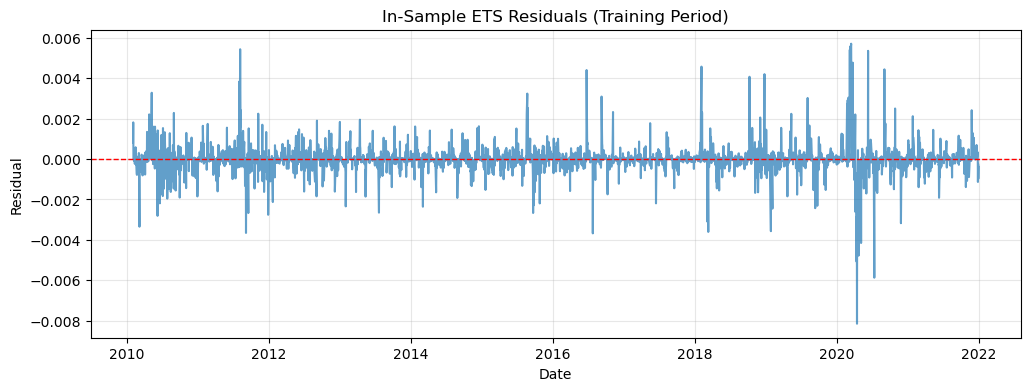

In [79]:
plt.figure(figsize=(12, 4))
plt.plot(in_sample_residuals.index, in_sample_residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("In-Sample ETS Residuals (Training Period)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.show()

Clear volatility clustering. Periods of calm with small errors interrupted by sharp spikes during crisis periods (2011-12, 2015-16, 2018, 2020), confirming heteroskedasticity that ETS cannot model.

## ACF

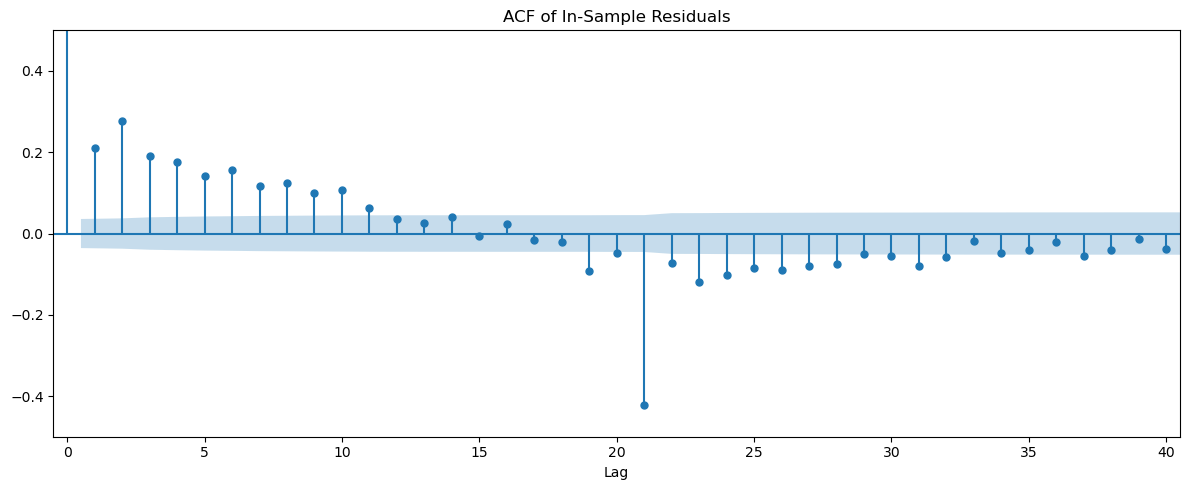

In [80]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(in_sample_residuals, lags=40, ax=ax)
plt.title("ACF of In-Sample Residuals")
plt.xlabel("Lag")
plt.ylim(-0.50, 0.50)
plt.xlim(-0.5, 40.5)
plt.tight_layout()
plt.show()

Strong positive autocorrelation at short lags (1-10) indicates the model fails to capture all the persistence in volatility, while the sharp negative spike at lag 21 is the mechanical artifact from the overlapping 21-day rolling window.

## Histogram of Standardised Residuals

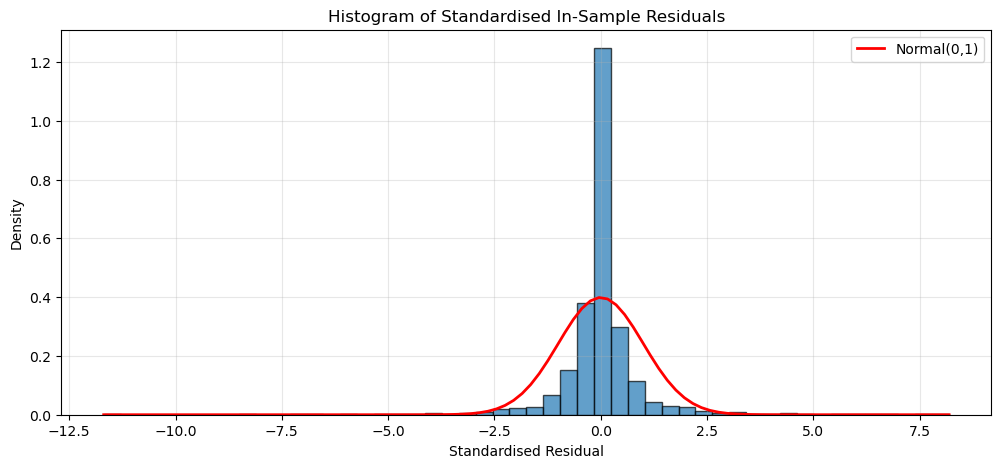

In [81]:
standardised_residuals = in_sample_residuals / in_sample_residuals.std()

plt.figure(figsize=(12, 5))
plt.hist(standardised_residuals, bins=50, density=True, alpha=0.7, edgecolor='black')

x = np.linspace(standardised_residuals.min(), standardised_residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='Normal(0,1)')

plt.title("Histogram of Standardised In-Sample Residuals")
plt.xlabel("Standardised Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The distribution is severely leptokurtic. Extremely peaked at the center with virtually no mass in the tails visible on this scale, yet the kurtosis of 23.85 confirms fat tails exist beyond the plot range, indicating rare extreme outliers dominate the tail behavior.

## Q-Q plot

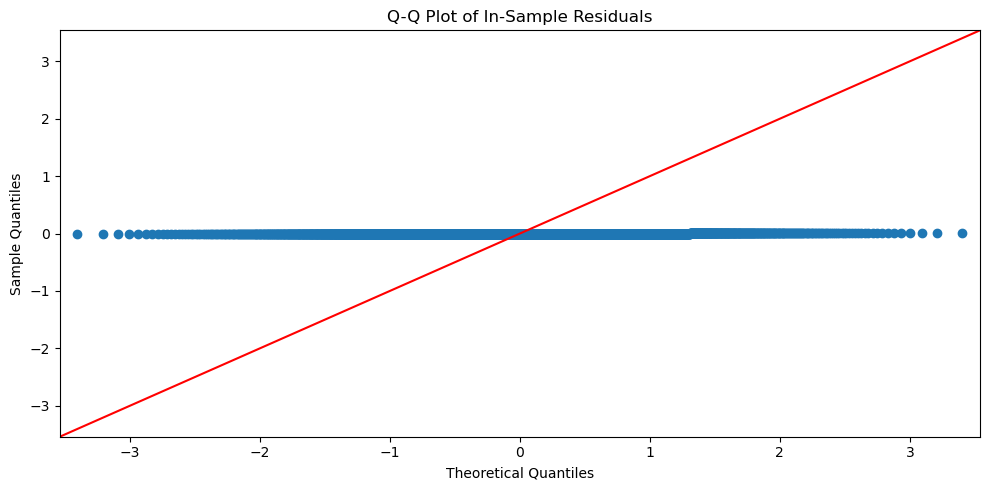

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
sm.qqplot(in_sample_residuals, line='45', ax=ax)
plt.title("Q-Q Plot of In-Sample Residuals")
plt.tight_layout()
plt.show()

The extreme horizontal compression of quantiles again confirms the distribution is massively leptokurtic. Most residuals cluster tightly near zero,appearing as a flat line, with a few extreme outliers in the tails that create the high kurtosis but aren't visible at this scale.

## Ljung-Box test

In [83]:
lb_residuals = acorr_ljungbox(in_sample_residuals, lags=[10, 20, 30], return_df=True)
print("\nTest for serial correlation in residuals:")
print(lb_residuals[['lb_stat', 'lb_pvalue']])


Test for serial correlation in residuals:
        lb_stat      lb_pvalue
10   852.245498  1.200205e-176
20   911.149416  3.329183e-180
30  1638.066763   0.000000e+00


Overwhelming evidence of serial correlation in residuals since p-values are essentially zero.

The in-sample residuals exhibit significant serial correlation, non-normality with extreme kurtosis, and clear volatility clustering patterns.

# Out-of-sample forecasting

While these diagnostics indicate the residuals are not white noise, we proceed with out-of-sample forecasting to evaluate the model's practical performance in a realistic setting.

In [84]:
history = train.copy()
ets_forecasts = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend=None,
        seasonal=None
    )
    fit = model.fit()
    forecast = fit.forecast(steps=1)
    ets_forecasts.append(forecast.iloc[0])
    history = pd.concat([history, test.iloc[t:t+1]])

An expanding-window approach is used to mirror real-time forecasting, although ETS forecasts are dominated by the most recent observation.

In [85]:
ets_forecasts = pd.Series(
    ets_forecasts,
    index=test.index
)

# Model evaluation

## Accuracy Metrics

In [86]:
ets_mae = mean_absolute_error(test, ets_forecasts)
ets_rmse = root_mean_squared_error(test, ets_forecasts)

pd.DataFrame({
    "Model": ["Naive Volatility", "ETS"],
    "MAE": [naive_mae, ets_mae],
    "RMSE": [naive_rmse, ets_rmse]
})

,Model,MAE,RMSE
0,Naive Volatility,0.000351,0.000592
1,ETS,0.000351,0.000592


ETS offers zero improvement over the naive forecast, confirming that at a one-day-ahead horizon, yesterday's 21-day volatility is already the optimal predictor.

## Forecast Bias

In [87]:
forecast_errors = test - ets_forecasts
mean_error = forecast_errors.mean()
print(f"Mean Forecast Error: {mean_error:.6f}")

Mean Forecast Error: -0.000002


Forecasts are essentially unbiased.

The mean error is negligible, indicating no systematic tendency to over- or under-predict volatility.

## Mincer-Zarnowitz Regression

Realized Vol = α + β × Forecast Vol + error

Optimal unbiased forecast: α = 0, β = 1

In [88]:
X = sm.add_constant(ets_forecasts)
mz_model = sm.OLS(test, X)
mz_results = mz_model.fit()

print(f"\nα (intercept): {mz_results.params.iloc[0]:.6f} (p-value: {mz_results.pvalues.iloc[0]:.4f})")
print(f"β (slope):     {mz_results.params.iloc[1]:.6f} (p-value: {mz_results.pvalues.iloc[1]:.4f})")
print(f"R-squared:     {mz_results.rsquared:.4f}")


α (intercept): 0.000101 (p-value: 0.0790)
β (slope):     0.990000 (p-value: 0.0000)
R-squared:     0.9799


Near-perfect forecast efficiency.

The slope is virtually 1.0, intercept is insignificant, and R² of 0.98 confirms forecasts are strongly aligned with realized volatility.

In [89]:
r_matrix = np.array([[1, 0], [0, 1]])  # Identity matrix for both parameters
q_matrix = np.array([0, 1])  # Test values: α=0, β=1

f_test = mz_results.f_test((r_matrix, q_matrix))
print(f"\nJoint test H0: α=0 and β=1")
print(f"F-statistic: {f_test.fvalue:.4f}")
print(f"p-value:     {f_test.pvalue:.4f}")


Joint test H0: α=0 and β=1
F-statistic: 1.8729
p-value:     0.1544


Test joint hypothesis: α = 0 and β = 1

Since p-value > 0.05, we canot reject H0.

The ETS forecasts are statistically unbiased and efficient, meaning they optimally use available information despite offering no improvement over the naive benchmark.

# Forecast visualisation

In [90]:
# Convert list of forecasts to pandas Series with correct index
ets_forecasts = pd.Series(ets_forecasts, index=test.index)

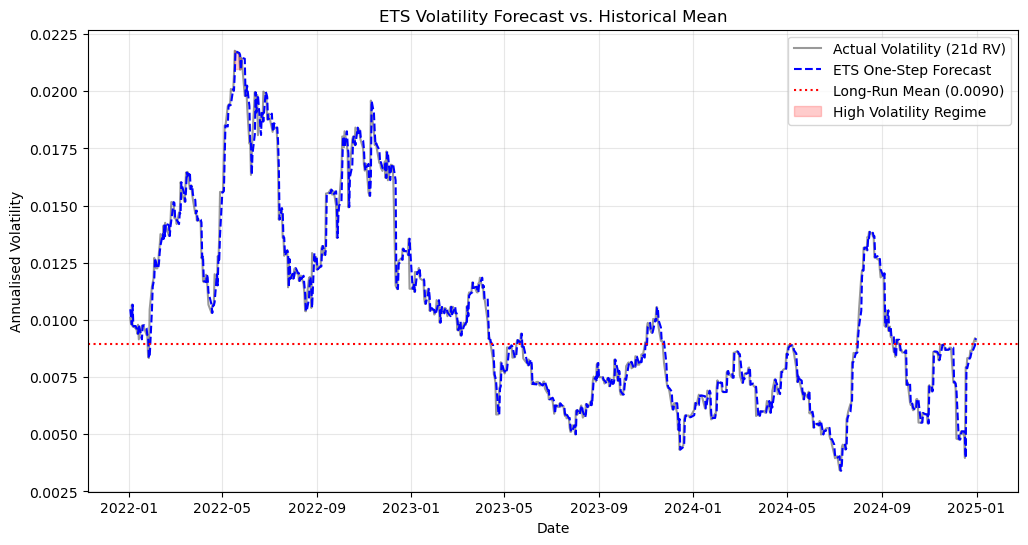

In [91]:
# Calculate Long-Run Mean from training data
long_run_mean = train.mean()

plt.figure(figsize=(12, 6))

# Plot actuals and forecasts
plt.plot(test.index, test, label="Actual Volatility (21d RV)", color='black', alpha=0.4)
plt.plot(test.index, ets_forecasts, label="ETS One-Step Forecast", color='blue', linestyle='--')

# Plot Long-Run Mean
plt.axhline(y=long_run_mean, color='red', linestyle=':', label=f"Long-Run Mean ({long_run_mean:.4f})")

# Highlight Regime Shifts (Example: High Volatility Periods)
high_vol_threshold = long_run_mean + (2 * train.std())
plt.fill_between(test.index, test, high_vol_threshold, 
                 where=(test > high_vol_threshold), color='red', alpha=0.2, label="High Volatility Regime")

plt.title("ETS Volatility Forecast vs. Historical Mean")
plt.xlabel("Date")
plt.ylabel("Annualised Volatility")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

Smooth tracking

Much smaller errors than returns

Volatility is theoretically mean-reverting in 2022

Missing High Volatility Regime

# Interpretation

At a one-step-ahead horizon, realised volatility is highly persistent, resulting in similar performance between naive and ETS forecasts. 

This highlights the strong memory inherent in volatility processes.

At short horizons, simple persistence-based forecasts are difficult to outperform.

Remaining signal cannot be extracted from the rolling series itself, necessitating the direct modelling of daily returns via GARCH.

# Save forecasts

In [92]:
ets_forecasts.to_csv("../outputs/forecasts/ets_volatility_forecast.csv")